# Linear Mixed Model

Linear mixed modeling `LMM` is a type of regression modeling approach that accounts for the violation of non-IID (independently and identically distributed) data. The problem of non-IID data is that using ordinary regression may underestimate the variance (standard error) of the parameter estimations and lead to incorrect hypothesis testing as well as a model that is no longer the Best Linear Unbiased Estimator `BLUE`. Additionally, LMM are useful for understand with and between group differences. 

There are many ways to combat non-IID:

- get a better model (eg use multilevel or linear mixed models)
- get a better variance estimator (eg Huber sandwich estimator)
- sample the data (eg Iteratively Reweighting Least Square)

In this notebook, we will focus on LMM and two ways to estimate the standard errors (maximum likelihood `ML` and restricted maximum likelihood `REML`). It should be noted that multilevel models are a type of LMM, but not all LMMs are multilevel. A LMM is denoted as follows, 

- $Y = X \beta + Z u + e$,

where

- $\beta$ are the coefficients (intercept and slope),
- $X$ is the design matrix (independent variables) of dimension $N$ x $M$ ($N$ rows and $M$ columns),
- $Z$ is a sparse indicator matrix of the group (of each observation in $X$) of dimension $N$ x $J$ ($N$ rows and $J$ columns),
- $u$ and $e$ are the error terms corresponding to $X$ and $Z$, respectively, and
- $Y$ is the dependent variable.

Note that $u$ and $e$ are column vectors assumed to be normally distributed with zero means as follows,

$\begin{pmatrix} u \\ e \end{pmatrix} \sim \mathcal{N} \begin{pmatrix} \begin{pmatrix} 0 \\ 0 \end{pmatrix}, \begin{pmatrix} G & 0 \\ 0 & R \end{pmatrix} \end{pmatrix}$

where

- $G_{JxJ} = I \sigma^2_{\mathrm{group}}$, and
- $R_{NxN} = I \sigma^2_{\mathrm{residual}}$.

For clarity, 

- $u \sim \mathcal{N}(0, G)$, and
- $e \sim \mathcal{N}(0, R)$.

The variables in $X$ are said to be `fixed effects` and the grouping variables in $Z$ are said to be the `random effects`. Grouping variables are categorical and can be quite complex in their relationship to one another. Grouping variables can be 

- nested (when the groups exists within other groups eg patients are observed only within a single hospital),
- partially crossed (when some groups are seen with others eg some patients are observed across some hospitals), or
- crossed (when all groups are seen with all other groups eg all patients are observed across all hospitals).

In mature LMM packages (e.g. [lme4](https://cran.r-project.org/web/packages/lme4/index.html)), these types of grouping relationships are easily expressed. 

The mixture of fixed and random effects is the `mixed` in linear mixed models `LMM`. 

- $V = Z G Z^T + R$
- $B = (X^T V^{-1} X)^{-1} X^T V^{-1} Y$
- $-2 L_{\mathrm{ML}}(\theta; Y) = \log |V| + (Y - X B_{\theta})^T V^{-1} (Y - X B_{\theta})$
- $-2 L_{\mathrm{REML}}(\theta; Y) = \log |V| + \log |X^T V^{-1} X| + (Y - X B_{\theta})^T V^{-1} (Y - X B_{\theta})$

## Data

This data is take from a [Littell 2006](https://www.amazon.com/Mixed-Models-Second-Ramon-Littell/dp/1590475003). In this data, we have 7 ingots, 3 metal types  and 1 dependent variable. 

In [1]:
import pandas as pd
import itertools

df = pd.DataFrame({
    'ingot': itertools.chain(*[[i + 1 for _ in range(3)] for i in range(7)]),
    'metal': ['n', 'i', 'c'] * 7,
    'pres': [67,71.9,72.2,67.5,68.8,66.4,76,82.6,74.5,72.7,78.1,67.3,73.1,74.2,73.2,65.8,70.8,68.7,75.6,84.9,69]
}).assign(
    ingot_1=lambda d: d['ingot'].apply(lambda i: 1 if i == 1 else 0),
    ingot_2=lambda d: d['ingot'].apply(lambda i: 1 if i == 2 else 0),
    ingot_3=lambda d: d['ingot'].apply(lambda i: 1 if i == 3 else 0),
    ingot_4=lambda d: d['ingot'].apply(lambda i: 1 if i == 4 else 0),
    ingot_5=lambda d: d['ingot'].apply(lambda i: 1 if i == 5 else 0),
    ingot_6=lambda d: d['ingot'].apply(lambda i: 1 if i == 6 else 0),
    ingot_7=lambda d: d['ingot'].apply(lambda i: 1 if i == 7 else 0)
)

df

,ingot,metal,pres,ingot_1,ingot_2,ingot_3,ingot_4,ingot_5,ingot_6,ingot_7
0,1,n,67.0,1,0,0,0,0,0,0
1,1,i,71.9,1,0,0,0,0,0,0
2,1,c,72.2,1,0,0,0,0,0,0
3,2,n,67.5,0,1,0,0,0,0,0
4,2,i,68.8,0,1,0,0,0,0,0
5,2,c,66.4,0,1,0,0,0,0,0
6,3,n,76.0,0,0,1,0,0,0,0
7,3,i,82.6,0,0,1,0,0,0,0
8,3,c,74.5,0,0,1,0,0,0,0
9,4,n,72.7,0,0,0,1,0,0,0


## Linear regression

In [23]:
from patsy import dmatrices, dmatrix
import numpy as np
from sklearn.linear_model import LinearRegression

f = 'pres ~ metal'
y, X = dmatrices(f, df, return_type='dataframe')
X = X.iloc[:,1:]
y = np.ravel(y)

X.shape, y.shape

model = LinearRegression().fit(X, y)
model.intercept_, model.coef_

(70.1857142857143, array([5.71428571, 0.91428571]))

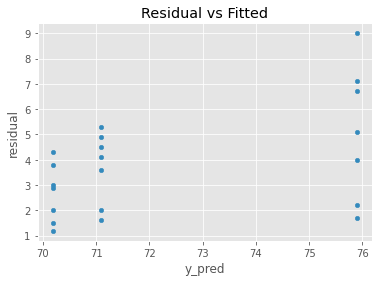

In [24]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')

_ = pd.DataFrame({
    'y': y,
    'y_pred': model.predict(X)
}).assign(residual=lambda d: np.abs(d['y'] - d['y_pred'])) \
.plot(kind='scatter', x='y_pred', y='residual', title='Residual vs Fitted')

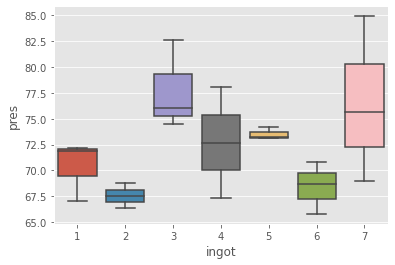

In [25]:
import seaborn as sns

_ = sns.boxplot(x='ingot', y='pres', data=df)

In [45]:
f = 'pres ~ metal + C(ingot)'
y, X = dmatrices(f, df, return_type='dataframe')
X = X.iloc[:,1:]
y = np.ravel(y)

model = LinearRegression().fit(X, y)
model.intercept_, model.coef_

(68.15714285714286,
 array([ 5.71428571,  0.91428571, -2.8       ,  7.33333333,  2.33333333,
         3.13333333, -1.93333333,  6.13333333]))

In [48]:
y = np.ravel(model.coef_[2:])
y = np.array([0] + list(model.intercept_ - y))

X = dmatrix('C(ingot)', df, return_type='dataframe')
X = X.iloc[:,1:].drop_duplicates().values

model = LinearRegression().fit(X, y)
model.intercept_, model.coef_

(0.0,
 array([70.95714286, 60.82380952, 65.82380952, 65.02380952, 70.09047619,
        62.02380952]))

In [61]:
X = df[[c for c in df.columns if c.startswith('ingot_') and c != 'ingot_1']].values
y = np.ravel(df['pres'])
y_pred = model.predict(X)
pd.DataFrame({
    'y': y,
    'y_pred': y_pred,
    'diff': y - y_pred
}).mean()

y         72.395238
y_pred    56.391837
diff      16.003401
dtype: float64

## LMM via ML

In [2]:
from patsy import dmatrices, dmatrix

f = 'pres ~ metal'
y, X = dmatrices(f, df, return_type='dataframe')

f = ' + '.join([f'ingot_{i+1}' for i in range(7)]) + ' - 1'
Z = dmatrix(f, df, return_type='dataframe')

y = y.values
X = X.values
Z = Z.values

X.shape, y.shape, Z.shape

((21, 3), (21, 1), (21, 7))

In [3]:
import numpy as np

x = np.array([1, 1])
G = x[0] * np.diag(np.ones(7))
R = x[1] * np.diag(np.ones(21))
V = Z.dot(G).dot(Z.T) + R
V_inv = np.linalg.inv(V)
X_T = X.T
B = np.linalg.inv(X_T.dot(V_inv).dot(X)).dot(X_T).dot(V_inv).dot(y)
LL = np.log(np.linalg.det(V)) + (y - (X.dot(B))).T.dot(V_inv).dot(y - (X.dot(B)))

In [4]:
from scipy.optimize import minimize

def log_ml(x):
    G = x[0] * np.diag(np.ones(7))
    R = x[1] * np.diag(np.ones(21))
    V = Z.dot(G).dot(Z.T) + R
    V_inv = np.linalg.inv(V)
    X_T = X.T
    B = np.linalg.inv(X_T.dot(V_inv).dot(X)).dot(X_T).dot(V_inv).dot(y)
    LL = np.log(np.linalg.det(V)) + (y - (X.dot(B))).T.dot(V_inv).dot(y - (X.dot(B)))
    
    return np.ravel(LL)[0]

r = minimize(fun=log_ml, x0=np.array([1, 1]), method='Nelder-Mead', tol=0.0000000000001, options={'maxiter': 500})
r

 final_simplex: (array([[9.81238077, 8.88993185],
       [9.81238077, 8.88993185],
       [9.81238077, 8.88993185]]), array([77.11196749, 77.11196749, 77.11196749]))
           fun: 77.11196749090402
       message: 'Optimization terminated successfully.'
          nfev: 253
           nit: 109
        status: 0
       success: True
             x: array([9.81238077, 8.88993185])

In [5]:
def hat_beta(x):
    G = x[0] * np.diag(np.ones(7))
    R = x[1] * np.diag(np.ones(21))
    V = Z.dot(G).dot(Z.T) + R
    V_inv = np.linalg.inv(V)
    X_T = X.T
    B = np.linalg.inv(X_T.dot(V_inv).dot(X)).dot(X_T).dot(V_inv).dot(y)
    
    return np.ravel(B)

hat_beta(r.x)

array([70.18571429,  5.71428571,  0.91428571])

## LMM via REML

In [6]:
def log_reml(x):
    G = x[0] * np.diag(np.ones(7))
    R = x[1] * np.diag(np.ones(21))
    V = Z.dot(G).dot(Z.T) + R
    V_inv = np.linalg.inv(V)
    X_T = X.T
    B = np.linalg.inv(X_T.dot(V_inv).dot(X)).dot(X_T).dot(V_inv).dot(y)
    LL = np.log(np.linalg.det(V)) + np.log(np.linalg.det(X.T.dot(V_inv).dot(X))) + (y - (X.dot(B))).T.dot(V_inv).dot(y - (X.dot(B)))
    
    return np.ravel(LL)[0]

r = minimize(fun=log_reml, x0=np.array([1, 1]), method='Nelder-Mead', tol=0.0000000000001, options={'maxiter': 500})
r

 final_simplex: (array([[11.44777794, 10.37158691],
       [11.44777794, 10.37158691],
       [11.44777794, 10.37158691]]), array([74.70841482, 74.70841482, 74.70841482]))
           fun: 74.7084148191172
       message: 'Optimization terminated successfully.'
          nfev: 244
           nit: 107
        status: 0
       success: True
             x: array([11.44777794, 10.37158691])

In [7]:
hat_beta(r.x)

array([70.18571429,  5.71428571,  0.91428571])